In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/Tetris/Torch')

import os
import pickle
import time
from datetime import datetime
from statistics import mean, median
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm
from collections import deque

from tetris import Tetris as TetrisA
from tetrisb import Tetris as TetrisB

from props_DQNTorch import DQNAgent 
from plotting import modified_plot


Mean Score ::  11.03 Best Score ::  31.0  -- Max Score ::  129
...saving checkpoint...
...saving checkpoint...
Mean Score ::  23.18 Best Score ::  50.0  -- Max Score ::  189
...saving checkpoint...
...saving checkpoint...
Mean Score ::  45.42 Best Score ::  111.0  -- Max Score ::  399
...saving checkpoint...
...saving checkpoint...
Mean Score ::  115.42 Best Score ::  348.0  -- Max Score ::  1119
...saving checkpoint...
...saving checkpoint...
Mean Score ::  125.16 Best Score ::  348.0  -- Max Score ::  1119
...saving checkpoint...
...saving checkpoint...
Mean Score ::  151.7 Best Score ::  348.0  -- Max Score ::  1289
...saving checkpoint...
...saving checkpoint...
Mean Score ::  141.83 Best Score ::  348.0  -- Max Score ::  1289
...saving checkpoint...
...saving checkpoint...
Mean Score ::  142.23 Best Score ::  348.0  -- Max Score ::  1289
...saving checkpoint...
...saving checkpoint...
Mean Score ::  140.16 Best Score ::  348.0  -- Max Score ::  1289
...saving checkpoint...
...savi

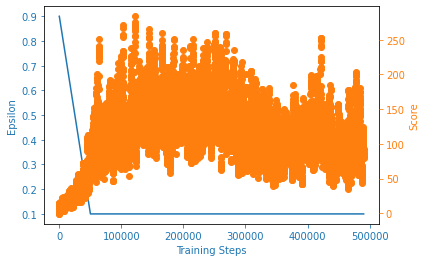

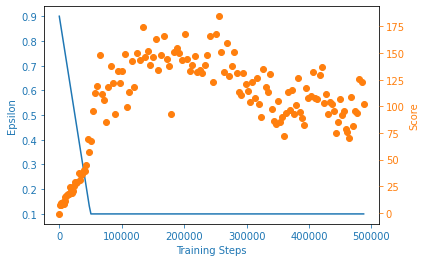

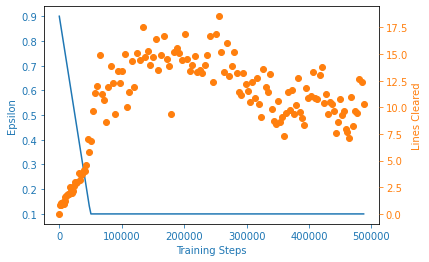

In [ ]:
baseRoot='/content/gdrive/MyDrive/Tetris/Torch/Runs'

env_name='SmallBoard'
if env_name=='FullBoard':
    env=TetrisA()
elif env_name=='SmallBoard':
    env=TetrisB()
else:
    print('NOT A CORRECT NAME SPECIFIED')
    exit()
big=False
### 10k episodes -- 200k frames
### 100k episodes --- 2m frames
if big:
  load_checkpoint=False
  start=0
  n_games=200_000
  epsilon=0.99
  gamma = 0.99
  lr=0.001
  epsilon_greedy_frames = 1_000_000
  epsilon_random_frames =1000
  epsilon_min = 0.1
  max_memory_length = 250_000
  update_network =5000
  batch_size =32
  num_actions=1
  algo='DQN_4Props_1Q'
  stepping=1000
else:
  load_checkpoint=False
  start=0
  n_games=15_000
  epsilon=0.9
  gamma = 0.99
  lr=0.0001
  epsilon_greedy_frames = 50_000
  epsilon_random_frames =1000
  epsilon_min = 0.1
  max_memory_length = 100_000
  update_network = 1000
  batch_size =32
  num_actions=1
  algo='DQN_4Props_1Q'
  stepping=100


##DIRECTORY MANAGE
baseRoot=os.path.join(baseRoot,algo)
if os.path.isdir(baseRoot):
    baseRoot=os.path.join(baseRoot,env_name)
    if os.path.isdir(baseRoot):
        pass
    else:
        os.mkdir(baseRoot)
else:
    os.mkdir(baseRoot)
    baseRoot=os.path.join(baseRoot,env_name)
    os.mkdir(baseRoot)

t = time.localtime()
current_time = time.asctime(t)
current_time=current_time.replace(':',' ')
Root=os.path.join(baseRoot,str(current_time))
os.mkdir(Root)
os.mkdir(Root+'/logs')
os.mkdir(Root+'/models')
os.mkdir(Root+'/buffer')
os.mkdir(Root+'/statistics')
#os.mkdir(Root+'/logs/eval')
log_summaries='/logs/summaries'
log_trainings='/logs/training'
load_folder=''


## ---- INITIALIZE
board_dim=np.expand_dims(np.array(env.board),axis=0).shape
inshape=env.get_state_size()
agent=DQNAgent(dims=inshape,epsilon =epsilon, gamma = gamma,lr=lr,
             epsilon_greedy_frames = epsilon_greedy_frames,
             epsilon_random_frames =epsilon_random_frames,
             epsilon_min = epsilon_min,
             max_memory_length = max_memory_length,
             update_network = update_network,
             batch_size =batch_size,num_actions=num_actions,
             algo=algo,
             chkpt_dir=Root,
             env_name=env_name)

with open(Root+log_trainings+'.txt','w') as c:
  c.write('Props :: Lines Cleared , Total Holes, Bumpiness , Sum Height')
  c.write('\n')
  c.write(f'Hyperparameters :: Starting model = {start},\
  epsilon = {epsilon}, \
  Learing Rate = {lr}, \
  gamma = {gamma}, \
  epsilon_greedy_frames = {epsilon_greedy_frames},\
  epsilon_random_frames ={epsilon_random_frames},\
  epsilon_min = {epsilon_min},\
  max_memory_length = {max_memory_length},\
  update_network = {update_network}, \
  batch_size ={batch_size},\
  Total Games ={n_games},\
  num_actions={num_actions}')
  c.write('\n')

if load_checkpoint:
    pass

best_score=0
max_score=0
flag=False
scores, eps_history, steps_array,stats,lines_c = [], [], [],[],[]
for episode in tqdm(range(start+1,n_games+1)):
    current_state=env.reset()
    done = False
    score=0
    tops=1000
    lines=0
    while not done :
        dic=env.get_next_states()
        action=agent.choose_action(dic)
        reward, done ,lc= env.play_g(action[0],action[1], render=False,
                              render_delay=0)
        next_state=dic[action]
        agent.store_transition(current_state,reward,next_state,done)
        agent.learn()
        current_state=next_state
        score+=reward
        lines+=lc
        if (score >tops):
            tops+=1000
            with open(Root+log_trainings+'.txt','a') as c:
              c.write(f'Score : {score} ')
              c.write('\n')
    scores.append(score)
    lines_c.append(lines)
    if score > max_score:
      max_score=score
    steps_array.append(agent.frames)
    eps_history.append(agent.epsilon)
    if episode % 10 == 0:
        avg_score = np.mean(scores[-10:])
        if avg_score>best_score:
            best_score=avg_score
        t = time.localtime()
        current_time = time.strftime("%H:%M:%S", t)
        with open(Root+log_trainings+'.txt','a') as c:
            c.write(f'episode: {episode} ,score: , {score}, lines cleared:{lines}\
average score {avg_score}, best score {best_score},\
epsilon {agent.epsilon},steps {agent.frames} ,time : {current_time}')
            c.write('\n')
    if (episode % 100)==0:
        summary={}
        summary['min'] = np.min(scores[-100:])
        summary['max'] = np.max(scores[-100:])
        summary['mean'] = np.mean(scores[-100:])
        stats.append(summary)
    if (episode % 1000)==0:
        print('Mean Score :: ',np.mean(scores[-1000:]),'Best Score :: ',best_score,' -- Max Score :: ',max_score)
        agent.save_models(episode)
        pickle.dump( scores, open( Root+'/statistics/scores.p', "wb" ))
        pickle.dump( stats, open( Root+'/statistics/summary.p', "wb" ))
        pickle.dump( steps_array, open( Root+'/statistics/steps.p', "wb" ))
        pickle.dump( eps_history, open( Root+'/statistics/eps_history.p', "wb" ))
        pickle.dump( lines_c, open( Root+'/statistics/lines_cleared.p', "wb" ))
    if (episode % 5000)==0:
        pass
        #agent.save_buffer(episode)

modified_plot(steps_array, scores, eps_history, Root+'/learning_score.png',stepping,'Score')
modified_plot(steps_array, lines_c, eps_history, Root+'/learning_lines.png',stepping,'Lines Cleared')